In [ ]:
import torch
from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video
from moviepy.editor import VideoClip, concatenate_videoclips #for video editing
from PIL import Image # for image processing
import numpy as np
import os

  if event.key is 'enter':



In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

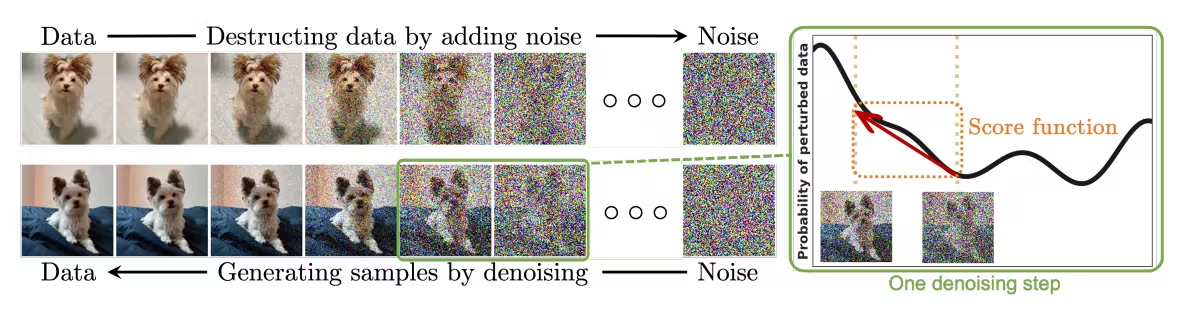

In [ ]:
# Load the Stable Video Diffusion model from Hugging face
pipe = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid",
    torch_dtype=torch.float16,#type of data for video
    variant="fp16",# version with type float16
    low_cpu_mem_usage=True  # Memory-efficient loading (low memory) low ram usage
).to(device)
pipe.enable_model_cpu_offload()  # Offload to CPU to save GPU memory

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Input image paths (add your image paths here)
image_paths = [
    "/content/photo_2025-05-31_10-28-12 (2).jpg",
    "/content/photo_2025-05-31_10-28-12 (3).jpg"


]

In [ ]:
output_video = "/content/output_video_svd_multi.mp4"  # Output video path
fps = 7  # Frames per second (each clip generates 14 frames)
clip_duration = 2  # Duration per clip in seconds (14 frames at 7 FPS ~ 2 seconds)

In [ ]:
# Function to convert frames to a MoviePy VideoClip
def make_clip(frames, fps):
    def make_frame(t):
        frame_idx = min(int(t * fps), len(frames) - 1) #detremine index frame
        return np.array(frames[frame_idx]) #convert to numpy for moviepy
    return VideoClip(make_frame, duration=len(frames) / fps) # moviepy class for video generate

In [ ]:
# Generate video clips for each image
clips = []
for img_path in image_paths:
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue
    # Load and preprocess the input image
    image = load_image(img_path)
    image = image.resize((576, 1024))  # Model expects 1024x576 resolution
    # Generate video frames
    torch.cuda.empty_cache()  # Clear GPU memory before each generation
    generator = torch.manual_seed(42)  # For reproducibility
    frames = pipe(
        image,
        decode_chunk_size=4,  # Reduced video to small for lower memory usage and decode 4 frame
        generator=generator,
        motion_bucket_id=127,  # Lower motion to reduce computation #میزان حرکت بین فریم ها
        noise_aug_strength=0.05  # Reduced noise for stability
    ).frames[0] #video 1 == batch
    # Convert frames to a MoviePy clip
    clip = make_clip(frames, fps)
    clips.append(clip)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
# Check if any clips were generated
if not clips:
    raise ValueError("No valid images were processed")

# Concatenate clips
final_clip = concatenate_videoclips(clips, method="compose")

# Save the video
final_clip.write_videofile(output_video, codec="libx264", audio=False, fps=fps)
#format = mp4 codec lib*264 and without audio
# Close clips to free memory
for clip in clips:
    clip.close()
final_clip.close()# close clip

print(f"Video saved as {output_video}")

Moviepy - Building video /content/output_video_svd_multi.mp4.
Moviepy - Writing video /content/output_video_svd_multi.mp4



Moviepy - Done !
Moviepy - video ready /content/output_video_svd_multi.mp4
Video saved as /content/output_video_svd_multi.mp4
